# Taller 2 - Embeddings, clasificación de texto y fine-tuning

Integrantes:

- Carlos Daniel Corrales Arango (2122878)
- Jose Manuel Palma Oquendo (2125182)

# Punto 3: Clasificación de texto - Análisis de sentimientos mediante Fine-tuning

El objetivo es ajustar este modelo para clasificar tweets como positivos, neutro y negativos, utilizando un dataset etiquetado Tweets específicamente para análisis de sentimientos.

## 3.1 Configuración inicial y autenticación en Hugging Face

In [ ]:
!pip install -q transformers datasets torch scikit-learn emoji matplotlib nltk tiktoken

In [ ]:
# aca va el login de HF

## 3.2 Carga y preprocesamiento del dataset

In [ ]:
import pandas as pd

# Cargar los datos
df_train = pd.read_csv('/content/cr-tass.csv')  # conjunto de entrenamiento
df_test = pd.read_csv('/content/cr1-tass.csv')  # conjunto de prueba

print("Tamaño del conjunto de entrenamiento:", df_train.shape)
print("Tamaño del conjunto de prueba:", df_test.shape)

Tamaño del conjunto de entrenamiento: (4802, 3)
Tamaño del conjunto de prueba: (2443, 3)


In [ ]:
print("Columnas del conjunto de entrenamiento:")
print(df_train.columns.tolist())

print("\nPrimeras filas:")
print(df_train.head())

Columnas del conjunto de entrenamiento:
['id', 'sentencia original', 'label']

Primeras filas:
                   id                                 sentencia original label
0  818942405281980417  No mames este pinche dolor que pedo? ya mejor ...     N
1  818963123646373892  @leomall2018 Según yo era como aviso, pero aho...   NEU
2  818998133694697472  @benshorts a juzgar por mis comportamientos au...     N
3  818822556090105857  #BuenosDias mundo Twittero ya desperté y estoy...     P
4  818993011514372098  No pude resolver el rompecabezas en Los rios d...     N


In [ ]:
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"http\S+", "", text)               # Eliminar URLs
    text = re.sub(r"@\w+", "@usuario", text)          # Normalizar menciones
    text = re.sub(r"#\w+", "", text)                  # Eliminar hashtags
    text = re.sub(r"[^\w\sáéíóúñüÁÉÍÓÚÑÜ.,!?]", " ", text)  # Solo letras/puntuación en español
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
# Asegurar columnas necesarias
df_train = df_train[['label', 'sentencia original']].dropna().reset_index(drop=True)
df_test = df_test[['label', 'sentencia original']].dropna().reset_index(drop=True)

# Filtrar solo las etiquetas que queremos: N, P, NUE
valid_labels = ['N', 'P', 'NUE']
df_train = df_train[df_train['label'].isin(valid_labels)].reset_index(drop=True)
df_test = df_test[df_test['label'].isin(valid_labels)].reset_index(drop=True)

# Limpiar texto
df_train['sentencia original'] = df_train['sentencia original'].apply(clean_text)
df_test['sentencia original'] = df_test['sentencia original'].apply(clean_text)

# Eliminar filas vacías tras limpieza
df_train = df_train[df_train['sentencia original'] != ""].reset_index(drop=True)
df_test = df_test[df_test['sentencia original'] != ""].reset_index(drop=True)

print("Tamaño después de limpieza y filtrado (train):", df_train.shape)
print("Tamaño después de limpieza y filtrado (test):", df_test.shape)

Tamaño después de limpieza y filtrado (train): (3279, 2)
Tamaño después de limpieza y filtrado (test): (1650, 2)


## 3.3 División de datos y tokenización

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir train en train + eval (20% para evaluación)
train_df, eval_df = train_test_split(
    df_train,
    test_size=0.2,
    random_state=42,
    stratify=df_train['label']  # mantener proporción de clases
)

print("Tamaño de train:", train_df.shape)
print("Tamaño de eval:", eval_df.shape)
print("Tamaño de test:", df_test.shape)

Tamaño de train: (2623, 2)
Tamaño de eval: (656, 2)
Tamaño de test: (1650, 2)


In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)
test_dataset = Dataset.from_pandas(df_test)

print("Dataset de entrenamiento:", train_dataset)
print("Dataset de evaluación:", eval_dataset)
print("Dataset de prueba:", test_dataset)

Dataset de entrenamiento: Dataset({
    features: ['label', 'sentencia original', '__index_level_0__'],
    num_rows: 2623
})
Dataset de evaluación: Dataset({
    features: ['label', 'sentencia original', '__index_level_0__'],
    num_rows: 656
})
Dataset de prueba: Dataset({
    features: ['label', 'sentencia original'],
    num_rows: 1650
})


In [ ]:
from transformers import AutoTokenizer

MODEL_NAME = "xlm-roberta-large"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Mapeo de etiquetas a números: NUE=0, P=1, N=2
label_map = {'NUE': 0, 'P': 1, 'N': 2}

def transform_labels(example):
    example['labels'] = label_map[example['label']]
    return example

def tokenize_data(example):
    return tokenizer(
        example['sentencia original'],
        truncation=True,
        padding='max_length',
        max_length=256,
        add_special_tokens=True
    )

# Aplicar transformaciones
train_dataset = train_dataset.map(tokenize_data, batched=True)
eval_dataset = eval_dataset.map(tokenize_data, batched=True)
test_dataset = test_dataset.map(tokenize_data, batched=True)

train_dataset = train_dataset.map(transform_labels)
eval_dataset = eval_dataset.map(transform_labels)
test_dataset = test_dataset.map(transform_labels)

# Eliminar columnas originales
cols_to_remove = ['label', 'sentencia original']
train_dataset = train_dataset.remove_columns(cols_to_remove)
eval_dataset = eval_dataset.remove_columns(cols_to_remove)
test_dataset = test_dataset.remove_columns(cols_to_remove)

# Formato PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
eval_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

print("Dataset de entrenamiento tokenizado:", train_dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/2623 [00:00<?, ? examples/s]

Map:   0%|          | 0/656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1650 [00:00<?, ? examples/s]

Map:   0%|          | 0/2623 [00:00<?, ? examples/s]

Map:   0%|          | 0/656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1650 [00:00<?, ? examples/s]

Dataset de entrenamiento tokenizado: Dataset({
    features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2623
})


## 3.4 Cálculo de pesos de clase (para manejo de desbalanceo)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Extraer etiquetas del conjunto de entrenamiento
train_labels = [int(ex['labels']) for ex in train_dataset]

# Clases únicas presentes en el conjunto de entrenamiento
unique_classes_in_train = np.unique(train_labels)
print("Clases presentes en entrenamiento:", unique_classes_in_train)

# Calcular pesos solo para las clases que aparecen
if len(unique_classes_in_train) > 1:
    class_weights_np = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes_in_train,
        y=train_labels
    )
else:
    # Si solo hay una clase, no hay desbalance → todos los pesos = 1
    class_weights_np = np.array([1.0])

# Crear array de tamaño 3 (para NUE=0, P=1, N=2)
full_class_weights = np.ones(3, dtype=np.float32)
for cls, weight in zip(unique_classes_in_train, class_weights_np):
    full_class_weights[cls] = weight

# CONVERTIR A TENSOR DE PYTORCH (esto es clave)
class_weights_tensor = torch.tensor(full_class_weights, dtype=torch.float)

print("Pesos de clase (tensor de PyTorch):", class_weights_tensor)

Clases presentes en entrenamiento: [1 2]
Pesos de clase (tensor de PyTorch): tensor([1.0000, 1.1762, 0.8697])


## 3.5 Definición del modelo, métricas y Trainer personalizado

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)

    # Calcular métricas por clase y promedio
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    prec_macro = precision_score(labels, predictions, average='macro', zero_division=0)
    rec_macro = recall_score(labels, predictions, average='macro', zero_division=0)

    return {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': prec_macro,
        'recall_macro': rec_macro
    }

In [ ]:
from transformers import Trainer
import torch.nn as nn

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

## 3.6 Entrenamiento con batch_size=8

In [ ]:
from transformers import TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./sentiment-xlm-roberta-large-3class",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    warmup_ratio=0.1,
    weight_decay=0.01,
    seed=42,
    report_to="none",
    fp16=True,  # Activar mixed precision (acelera en GPU)
    gradient_accumulation_steps=1  # No acumular gradientes (a menos que batch sea muy pequeño)
)

In [ ]:
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
print("\n🚀 Iniciando entrenamiento con XLM-Roberta-Large...")
trainer.train()


🚀 Iniciando entrenamiento con XLM-Roberta-Large...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,0.664100,0.632193,0.830793,0.823076,0.828596,0.834856,0.817846
2,0.489000,0.465173,0.855183,0.848975,0.853549,0.859641,0.843725
3,0.451800,0.475582,0.824695,0.811264,0.818785,0.847243,0.802758
4,0.381900,0.528169,0.865854,0.861048,0.864908,0.867429,0.857201
5,0.314900,0.520755,0.871951,0.867364,0.871049,0.873845,0.863438
6,0.245200,0.727098,0.873476,0.867163,0.871489,0.883572,0.860106
7,0.156800,0.808397,0.873476,0.870765,0.873561,0.870283,0.871286
8,0.101100,0.795255,0.876524,0.873992,0.876661,0.873221,0.874870
9,0.079000,0.948123,0.867378,0.865525,0.867883,0.863652,0.869242
10,0.047200,0.951965,0.871951,0.869382,0.872119,0.868492,0.870426


TrainOutput(global_step=3280, training_loss=0.2930944553235682, metrics={'train_runtime': 2906.7381, 'train_samples_per_second': 9.024, 'train_steps_per_second': 1.128, 'total_flos': 1.222232112655872e+16, 'train_loss': 0.2930944553235682, 'epoch': 10.0})

In [ ]:
print("\nEvaluando en conjunto de prueba")
test_results = trainer.evaluate(eval_dataset=test_dataset)
print("Resultados en test:", test_results)


Evaluando en conjunto de prueba


Resultados en test: {'eval_loss': 0.8391779065132141, 'eval_accuracy': 0.8703030303030304, 'eval_f1_macro': 0.8677329937069224, 'eval_f1_weighted': 0.8705488598904841, 'eval_precision_macro': 0.866500748720904, 'eval_recall_macro': 0.8692905141639927, 'eval_runtime': 16.8475, 'eval_samples_per_second': 97.938, 'eval_steps_per_second': 12.287, 'epoch': 10.0}


In [ ]:
trainer.push_to_hub("Carlosdca/sentiment-xlm-batch8")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...s/sentencepiece.bpe.model:  96%|#########6| 4.87MB / 5.07MB            

  ...rge-3class/tokenizer.json: 100%|##########| 17.1MB / 17.1MB            

  ...-3class/model.safetensors:   0%|          |  555kB / 2.24GB            

  ...-3class/training_args.bin:  14%|#4        |   843B / 5.84kB            

CommitInfo(commit_url='https://huggingface.co/Carlosdca/sentiment-xlm-roberta-large-3class/commit/8ab949dbf4b6e12a61e154525adf446d4342affe', commit_message='Carlosdca/sentiment-xlm-batch8', commit_description='', oid='8ab949dbf4b6e12a61e154525adf446d4342affe', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Carlosdca/sentiment-xlm-roberta-large-3class', endpoint='https://huggingface.co', repo_type='model', repo_id='Carlosdca/sentiment-xlm-roberta-large-3class'), pr_revision=None, pr_num=None)

In [ ]:
import json

# Evaluar en test
test_results = trainer.evaluate(eval_dataset=test_dataset)

# Guardar resultados en un diccionario con identificador
results_batch8 = {
    "config": "batch_size=8",
    "test_accuracy": test_results["eval_accuracy"],
    "test_f1_macro": test_results["eval_f1_macro"],
    "test_f1_weighted": test_results["eval_f1_weighted"],
    "test_loss": test_results["eval_loss"]
}

# Guardar como JSON
with open("results_batch8.json", "w") as f:
    json.dump(results_batch8, f, indent=4)

print("Resultados guardados en results_batch8.json")

Resultados guardados en results_batch8.json


In [ ]:
import shutil

# Borrar la carpeta completa del modelo anterior
model_dir = "./sentiment-xlm-roberta-large-3class"

try:
    shutil.rmtree(model_dir)
    print(f"Carpeta '{model_dir}' eliminada con éxito.")
except FileNotFoundError:
    print(f"La carpeta '{model_dir}' no existe.")
except Exception as e:
    print(f"Error al eliminar la carpeta: {e}")

Carpeta './sentiment-xlm-roberta-large-3class' eliminada con éxito.


In [ ]:
# --- CONFIGURACIÓN BATCH=4 ---
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback

# Cargar modelo
model4 = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-large", num_labels=3
)

training_args4 = TrainingArguments(
    output_dir="./sentiment-xlm-batch4",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    warmup_ratio=0.1,
    weight_decay=0.01,
    seed=42,
    report_to="none",
    fp16=True,
)

trainer4 = WeightedLossTrainer(
    model=model4,
    args=training_args4,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print("\nEntrenando con batch_size=4...")
trainer4.train()

In [ ]:
# Evaluar y guardar
test_results4 = trainer4.evaluate(eval_dataset=test_dataset)
with open("results_batch4.json", "w") as f:
    json.dump({**{"config": "batch_size=4"}, **test_results4}, f, indent=4)

In [ ]:
# Subir a HF
trainer4.push_to_hub("Carlosdca/sentiment-xlm-batch4")
print("Modelo batch=4 subido")

# Configuracion 2 con batch_size = 4


In [ ]:
!pip install -q transformers datasets torch scikit-learn emoji matplotlib nltk tiktoken

In [ ]:
# aca va el login de HF

In [ ]:
import pandas as pd

# Cargar los datos
df_train = pd.read_csv('/content/cr-tass.csv')  # conjunto de entrenamiento
df_test = pd.read_csv('/content/cr1-tass.csv')  # conjunto de prueba

print("Tamaño del conjunto de entrenamiento:", df_train.shape)
print("Tamaño del conjunto de prueba:", df_test.shape)

Tamaño del conjunto de entrenamiento: (4802, 3)
Tamaño del conjunto de prueba: (2443, 3)


In [ ]:
print("Columnas del conjunto de entrenamiento:")
print(df_train.columns.tolist())

print("\nPrimeras filas:")
print(df_train.head())

Columnas del conjunto de entrenamiento:
['id', 'sentencia original', 'label']

Primeras filas:
                   id                                 sentencia original label
0  818942405281980417  No mames este pinche dolor que pedo? ya mejor ...     N
1  818963123646373892  @leomall2018 Según yo era como aviso, pero aho...   NEU
2  818998133694697472  @benshorts a juzgar por mis comportamientos au...     N
3  818822556090105857  #BuenosDias mundo Twittero ya desperté y estoy...     P
4  818993011514372098  No pude resolver el rompecabezas en Los rios d...     N


In [ ]:
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"http\S+", "", text)               # Eliminar URLs
    text = re.sub(r"@\w+", "@usuario", text)          # Normalizar menciones
    text = re.sub(r"#\w+", "", text)                  # Eliminar hashtags
    text = re.sub(r"[^\w\sáéíóúñüÁÉÍÓÚÑÜ.,!?]", " ", text)  # Solo letras/puntuación en español
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
# Asegurar columnas necesarias
df_train = df_train[['label', 'sentencia original']].dropna().reset_index(drop=True)
df_test = df_test[['label', 'sentencia original']].dropna().reset_index(drop=True)

# Filtrar solo las etiquetas que queremos: N, P, NUE
valid_labels = ['N', 'P', 'NUE']
df_train = df_train[df_train['label'].isin(valid_labels)].reset_index(drop=True)
df_test = df_test[df_test['label'].isin(valid_labels)].reset_index(drop=True)

# Limpiar texto
df_train['sentencia original'] = df_train['sentencia original'].apply(clean_text)
df_test['sentencia original'] = df_test['sentencia original'].apply(clean_text)

# Eliminar filas vacías tras limpieza
df_train = df_train[df_train['sentencia original'] != ""].reset_index(drop=True)
df_test = df_test[df_test['sentencia original'] != ""].reset_index(drop=True)

print("Tamaño después de limpieza y filtrado (train):", df_train.shape)
print("Tamaño después de limpieza y filtrado (test):", df_test.shape)

Tamaño después de limpieza y filtrado (train): (3279, 2)
Tamaño después de limpieza y filtrado (test): (1650, 2)


In [ ]:
from sklearn.model_selection import train_test_split

# Dividir train en train + eval (20% para evaluación)
train_df, eval_df = train_test_split(
    df_train,
    test_size=0.2,
    random_state=42,
    stratify=df_train['label']  # mantener proporción de clases
)

print("Tamaño de train:", train_df.shape)
print("Tamaño de eval:", eval_df.shape)
print("Tamaño de test:", df_test.shape)

Tamaño de train: (2623, 2)
Tamaño de eval: (656, 2)
Tamaño de test: (1650, 2)


In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)
test_dataset = Dataset.from_pandas(df_test)

print("Dataset de entrenamiento:", train_dataset)
print("Dataset de evaluación:", eval_dataset)
print("Dataset de prueba:", test_dataset)

Dataset de entrenamiento: Dataset({
    features: ['label', 'sentencia original', '__index_level_0__'],
    num_rows: 2623
})
Dataset de evaluación: Dataset({
    features: ['label', 'sentencia original', '__index_level_0__'],
    num_rows: 656
})
Dataset de prueba: Dataset({
    features: ['label', 'sentencia original'],
    num_rows: 1650
})


In [ ]:
from transformers import AutoTokenizer

MODEL_NAME = "xlm-roberta-large"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Mapeo de etiquetas a números: NUE=0, P=1, N=2
label_map = {'NUE': 0, 'P': 1, 'N': 2}

def transform_labels(example):
    example['labels'] = label_map[example['label']]
    return example

def tokenize_data(example):
    return tokenizer(
        example['sentencia original'],
        truncation=True,
        padding='max_length',
        max_length=256,
        add_special_tokens=True
    )

# Aplicar transformaciones
train_dataset = train_dataset.map(tokenize_data, batched=True)
eval_dataset = eval_dataset.map(tokenize_data, batched=True)
test_dataset = test_dataset.map(tokenize_data, batched=True)

train_dataset = train_dataset.map(transform_labels)
eval_dataset = eval_dataset.map(transform_labels)
test_dataset = test_dataset.map(transform_labels)

# Eliminar columnas originales
cols_to_remove = ['label', 'sentencia original']
train_dataset = train_dataset.remove_columns(cols_to_remove)
eval_dataset = eval_dataset.remove_columns(cols_to_remove)
test_dataset = test_dataset.remove_columns(cols_to_remove)

# Formato PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
eval_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

print("Dataset de entrenamiento tokenizado:", train_dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/2623 [00:00<?, ? examples/s]

Map:   0%|          | 0/656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1650 [00:00<?, ? examples/s]

Map:   0%|          | 0/2623 [00:00<?, ? examples/s]

Map:   0%|          | 0/656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1650 [00:00<?, ? examples/s]

Dataset de entrenamiento tokenizado: Dataset({
    features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2623
})


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Extraer etiquetas del conjunto de entrenamiento
train_labels = [int(ex['labels']) for ex in train_dataset]

# Clases únicas presentes en el conjunto de entrenamiento
unique_classes_in_train = np.unique(train_labels)
print("Clases presentes en entrenamiento:", unique_classes_in_train)

# Calcular pesos solo para las clases que aparecen
if len(unique_classes_in_train) > 1:
    class_weights_np = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes_in_train,
        y=train_labels
    )
else:
    # Si solo hay una clase, no hay desbalance → todos los pesos = 1
    class_weights_np = np.array([1.0])

# Crear array de tamaño 3 (para NUE=0, P=1, N=2)
full_class_weights = np.ones(3, dtype=np.float32)
for cls, weight in zip(unique_classes_in_train, class_weights_np):
    full_class_weights[cls] = weight

# CONVERTIR A TENSOR DE PYTORCH (esto es clave)
class_weights_tensor = torch.tensor(full_class_weights, dtype=torch.float)

print("Pesos de clase (tensor de PyTorch):", class_weights_tensor)

Clases presentes en entrenamiento: [1 2]
Pesos de clase (tensor de PyTorch): tensor([1.0000, 1.1762, 0.8697])


In [ ]:
from transformers import AutoModelForSequenceClassification

num_classes = 3

model4 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)

    # Calcular métricas por clase y promedio
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    prec_macro = precision_score(labels, predictions, average='macro', zero_division=0)
    rec_macro = recall_score(labels, predictions, average='macro', zero_division=0)

    return {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': prec_macro,
        'recall_macro': rec_macro
    }

In [ ]:
from transformers import Trainer
import torch.nn as nn

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import TrainingArguments, EarlyStoppingCallback

training_args4 = TrainingArguments(
    output_dir="./sentiment-xlm-batch4",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    warmup_ratio=0.1,
    weight_decay=0.01,
    seed=42,
    report_to="none",
    fp16=True,
)

In [ ]:
trainer4 = WeightedLossTrainer(
    model=model4,
    args=training_args4,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
print("\nEntrenando con batch_size=4...")
trainer4.train()


Entrenando con batch_size=4...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,0.740800,0.676365,0.574695,0.364956,0.419477,0.287348,0.500000
2,0.716500,0.697925,0.425305,0.298396,0.253818,0.212652,0.500000
3,0.707100,0.722191,0.425305,0.298396,0.253818,0.212652,0.500000
4,0.705000,0.697576,0.425305,0.298396,0.253818,0.212652,0.500000


TrainOutput(global_step=2624, training_loss=0.7173614269349633, metrics={'train_runtime': 1183.8658, 'train_samples_per_second': 22.156, 'train_steps_per_second': 5.541, 'total_flos': 4888928450623488.0, 'train_loss': 0.7173614269349633, 'epoch': 4.0})

In [ ]:
import json

# Evaluar y guardar
test_results4 = trainer4.evaluate(eval_dataset=test_dataset)
with open("results_batch4.json", "w") as f:
    json.dump({**{"config": "batch_size=4"}, **test_results4}, f, indent=4)

In [ ]:
# Subir a HF
trainer4.push_to_hub("Carlosdca/sentiment-xlm-batch4")
print("Modelo batch=4 subido")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...4/sentencepiece.bpe.model: 100%|##########| 5.07MB / 5.07MB            

  ...xlm-batch4/tokenizer.json:  98%|#########7| 16.7MB / 17.1MB            

  ...-batch4/model.safetensors:   0%|          |  555kB / 2.24GB            

  ...-batch4/training_args.bin:  15%|#4        |   861B / 5.84kB            

Modelo batch=4 subido


In [ ]:
import shutil

# Borrar la carpeta completa del modelo anterior
model_dir = "./sentiment-xlm-batch4"

try:
    shutil.rmtree(model_dir)
    print(f"Carpeta '{model_dir}' eliminada con éxito.")
except FileNotFoundError:
    print(f"La carpeta '{model_dir}' no existe.")
except Exception as e:
    print(f"Error al eliminar la carpeta: {e}")

Carpeta './sentiment-xlm-batch4' eliminada con éxito.


# Configuracion 3 con batch_size = 16


In [ ]:
!pip install -q transformers datasets torch scikit-learn emoji matplotlib nltk tiktoken

In [ ]:
# aca va el login de HF

In [ ]:
import pandas as pd

# Cargar los datos
df_train = pd.read_csv('/content/cr-tass.csv')  # conjunto de entrenamiento
df_test = pd.read_csv('/content/cr1-tass.csv')  # conjunto de prueba

print("Tamaño del conjunto de entrenamiento:", df_train.shape)
print("Tamaño del conjunto de prueba:", df_test.shape)

Tamaño del conjunto de entrenamiento: (4802, 3)
Tamaño del conjunto de prueba: (2443, 3)


In [ ]:
print("Columnas del conjunto de entrenamiento:")
print(df_train.columns.tolist())

print("\nPrimeras filas:")
print(df_train.head())

Columnas del conjunto de entrenamiento:
['id', 'sentencia original', 'label']

Primeras filas:
                   id                                 sentencia original label
0  818942405281980417  No mames este pinche dolor que pedo? ya mejor ...     N
1  818963123646373892  @leomall2018 Según yo era como aviso, pero aho...   NEU
2  818998133694697472  @benshorts a juzgar por mis comportamientos au...     N
3  818822556090105857  #BuenosDias mundo Twittero ya desperté y estoy...     P
4  818993011514372098  No pude resolver el rompecabezas en Los rios d...     N


In [ ]:
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"http\S+", "", text)               # Eliminar URLs
    text = re.sub(r"@\w+", "@usuario", text)          # Normalizar menciones
    text = re.sub(r"#\w+", "", text)                  # Eliminar hashtags
    text = re.sub(r"[^\w\sáéíóúñüÁÉÍÓÚÑÜ.,!?]", " ", text)  # Solo letras/puntuación en español
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
# Asegurar columnas necesarias
df_train = df_train[['label', 'sentencia original']].dropna().reset_index(drop=True)
df_test = df_test[['label', 'sentencia original']].dropna().reset_index(drop=True)

# Filtrar solo las etiquetas que queremos: N, P, NUE
valid_labels = ['N', 'P', 'NUE']
df_train = df_train[df_train['label'].isin(valid_labels)].reset_index(drop=True)
df_test = df_test[df_test['label'].isin(valid_labels)].reset_index(drop=True)

# Limpiar texto
df_train['sentencia original'] = df_train['sentencia original'].apply(clean_text)
df_test['sentencia original'] = df_test['sentencia original'].apply(clean_text)

# Eliminar filas vacías tras limpieza
df_train = df_train[df_train['sentencia original'] != ""].reset_index(drop=True)
df_test = df_test[df_test['sentencia original'] != ""].reset_index(drop=True)

print("Tamaño después de limpieza y filtrado (train):", df_train.shape)
print("Tamaño después de limpieza y filtrado (test):", df_test.shape)

Tamaño después de limpieza y filtrado (train): (3279, 2)
Tamaño después de limpieza y filtrado (test): (1650, 2)


In [ ]:
from sklearn.model_selection import train_test_split

# Dividir train en train + eval (20% para evaluación)
train_df, eval_df = train_test_split(
    df_train,
    test_size=0.2,
    random_state=42,
    stratify=df_train['label']  # mantener proporción de clases
)

print("Tamaño de train:", train_df.shape)
print("Tamaño de eval:", eval_df.shape)
print("Tamaño de test:", df_test.shape)

Tamaño de train: (2623, 2)
Tamaño de eval: (656, 2)
Tamaño de test: (1650, 2)


In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)
test_dataset = Dataset.from_pandas(df_test)

print("Dataset de entrenamiento:", train_dataset)
print("Dataset de evaluación:", eval_dataset)
print("Dataset de prueba:", test_dataset)

Dataset de entrenamiento: Dataset({
    features: ['label', 'sentencia original', '__index_level_0__'],
    num_rows: 2623
})
Dataset de evaluación: Dataset({
    features: ['label', 'sentencia original', '__index_level_0__'],
    num_rows: 656
})
Dataset de prueba: Dataset({
    features: ['label', 'sentencia original'],
    num_rows: 1650
})


In [ ]:
from transformers import AutoTokenizer

MODEL_NAME = "xlm-roberta-large"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Mapeo de etiquetas a números: NUE=0, P=1, N=2
label_map = {'NUE': 0, 'P': 1, 'N': 2}

def transform_labels(example):
    example['labels'] = label_map[example['label']]
    return example

def tokenize_data(example):
    return tokenizer(
        example['sentencia original'],
        truncation=True,
        padding='max_length',
        max_length=256,
        add_special_tokens=True
    )

# Aplicar transformaciones
train_dataset = train_dataset.map(tokenize_data, batched=True)
eval_dataset = eval_dataset.map(tokenize_data, batched=True)
test_dataset = test_dataset.map(tokenize_data, batched=True)

train_dataset = train_dataset.map(transform_labels)
eval_dataset = eval_dataset.map(transform_labels)
test_dataset = test_dataset.map(transform_labels)

# Eliminar columnas originales
cols_to_remove = ['label', 'sentencia original']
train_dataset = train_dataset.remove_columns(cols_to_remove)
eval_dataset = eval_dataset.remove_columns(cols_to_remove)
test_dataset = test_dataset.remove_columns(cols_to_remove)

# Formato PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
eval_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

print("Dataset de entrenamiento tokenizado:", train_dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/2623 [00:00<?, ? examples/s]

Map:   0%|          | 0/656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1650 [00:00<?, ? examples/s]

Map:   0%|          | 0/2623 [00:00<?, ? examples/s]

Map:   0%|          | 0/656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1650 [00:00<?, ? examples/s]

Dataset de entrenamiento tokenizado: Dataset({
    features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2623
})


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Extraer etiquetas del conjunto de entrenamiento
train_labels = [int(ex['labels']) for ex in train_dataset]

# Clases únicas presentes en el conjunto de entrenamiento
unique_classes_in_train = np.unique(train_labels)
print("Clases presentes en entrenamiento:", unique_classes_in_train)

# Calcular pesos solo para las clases que aparecen
if len(unique_classes_in_train) > 1:
    class_weights_np = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes_in_train,
        y=train_labels
    )
else:
    # Si solo hay una clase, no hay desbalance → todos los pesos = 1
    class_weights_np = np.array([1.0])

# Crear array de tamaño 3 (para NUE=0, P=1, N=2)
full_class_weights = np.ones(3, dtype=np.float32)
for cls, weight in zip(unique_classes_in_train, class_weights_np):
    full_class_weights[cls] = weight

# CONVERTIR A TENSOR DE PYTORCH
class_weights_tensor = torch.tensor(full_class_weights, dtype=torch.float)

print("Pesos de clase (tensor de PyTorch):", class_weights_tensor)

Clases presentes en entrenamiento: [1 2]
Pesos de clase (tensor de PyTorch): tensor([1.0000, 1.1762, 0.8697])


In [ ]:
from transformers import AutoModelForSequenceClassification

num_classes = 3

model16 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)

    # Calcular métricas por clase y promedio
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    prec_macro = precision_score(labels, predictions, average='macro', zero_division=0)
    rec_macro = recall_score(labels, predictions, average='macro', zero_division=0)

    return {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': prec_macro,
        'recall_macro': rec_macro
    }

In [ ]:
from transformers import Trainer
import torch.nn as nn

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import TrainingArguments, EarlyStoppingCallback

training_args16 = TrainingArguments(
    output_dir="./sentiment-xlm-batch16",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    warmup_ratio=0.1,
    weight_decay=0.01,
    seed=42,
    report_to="none",
    fp16=True,
)

In [ ]:
trainer16 = WeightedLossTrainer(
    model=model16,
    args=training_args16,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
print("\nEntrenando con batch_size=16...")
trainer16.train()


Entrenando con batch_size=16...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,0.717800,0.439177,0.846037,0.845597,0.846828,0.849862,0.857197
2,0.391700,0.397937,0.865854,0.864397,0.866496,0.862744,0.869779
3,0.297100,0.404216,0.864329,0.862628,0.864912,0.860795,0.867056
4,0.231300,0.629103,0.873476,0.871614,0.873923,0.869737,0.875013
5,0.194300,0.643898,0.891768,0.887825,0.890967,0.895023,0.883475
6,0.133200,0.650371,0.884146,0.882485,0.884572,0.880517,0.886160
7,0.074900,0.666859,0.890244,0.887943,0.890342,0.887286,0.888670
8,0.065700,0.807473,0.878049,0.875380,0.878104,0.875046,0.875731
9,0.034300,0.882199,0.876524,0.873992,0.876661,0.873221,0.874870
10,0.048800,0.872825,0.878049,0.875602,0.878208,0.874696,0.876663


TrainOutput(global_step=1640, training_loss=0.21891448207017852, metrics={'train_runtime': 1939.8716, 'train_samples_per_second': 13.522, 'train_steps_per_second': 0.845, 'total_flos': 1.222232112655872e+16, 'train_loss': 0.21891448207017852, 'epoch': 10.0})

In [ ]:
import json

# Evaluar y guardar
test_results16 = trainer16.evaluate(eval_dataset=test_dataset)
with open("results_batch16.json", "w") as f:
    json.dump({**{"config": "batch_size=16"}, **test_results16}, f, indent=4)

In [ ]:
# Subir a HF
trainer16.push_to_hub("Carlosdca/sentiment-xlm-batch16")
print("Modelo batch=16 subido")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...6/sentencepiece.bpe.model: 100%|##########| 5.07MB / 5.07MB            

  ...lm-batch16/tokenizer.json:  98%|#########7| 16.7MB / 17.1MB            

  ...batch16/model.safetensors:   0%|          |  554kB / 2.24GB            

  ...batch16/training_args.bin:  14%|#4        |   840B / 5.84kB            

Modelo batch=16 subido


In [ ]:
import shutil

# Borrar la carpeta completa del modelo anterior
model_dir = "./sentiment-xlm-batch16"

try:
    shutil.rmtree(model_dir)
    print(f"Carpeta '{model_dir}' eliminada con éxito.")
except FileNotFoundError:
    print(f"La carpeta '{model_dir}' no existe.")
except Exception as e:
    print(f"Error al eliminar la carpeta: {e}")

Carpeta './sentiment-xlm-batch16' eliminada con éxito.


# Pruebas finales

## Pipeline para modelo con batch_size=8

In [2]:
from transformers import pipeline

# Cargar modelo desde Hugging Face
pipe8 = pipeline("text-classification", model="Carlosdca/sentiment-xlm-roberta-large-3class")

# Mapeo de etiquetas
id2label = {0: "NUE", 1: "P", 2: "N"}

def predict8(text):
    result = pipe8(text)[0]
    label_id = int(result['label'].replace('LABEL_', ''))
    return {"text": text, "label": id2label[label_id], "confidence": round(result['score'], 4)}

# Ejemplos de prueba
examples = [
    "Me encanta este curso de PLN",
    "Hoy es un día normal, nada especial",
    "Odio cuando la conexión a internet falla"
]

print("Predicciones del modelo (batch_size=8):")
for ex in examples:
    print(predict8(ex))

config.json:   0%|          | 0.00/880 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cuda:0


Predicciones del modelo (batch_size=8):
{'text': 'Me encanta este curso de PLN', 'label': 'P', 'confidence': 0.9999}
{'text': 'Hoy es un día normal, nada especial', 'label': 'P', 'confidence': 0.9985}
{'text': 'Odio cuando la conexión a internet falla', 'label': 'N', 'confidence': 0.9976}


## Pipeline para modelo con batch_size=4

In [3]:
from transformers import pipeline

pipe4 = pipeline("text-classification", model="Carlosdca/sentiment-xlm-batch4")

id2label = {0: "NUE", 1: "P", 2: "N"}

def predict4(text):
    result = pipe4(text)[0]
    label_id = int(result['label'].replace('LABEL_', ''))
    return {"text": text, "label": id2label[label_id], "confidence": round(result['score'], 4)}

print("\nPredicciones del modelo (batch_size=4):")
for ex in examples:
    print(predict4(ex))

config.json:   0%|          | 0.00/880 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cuda:0



Predicciones del modelo (batch_size=4):
{'text': 'Me encanta este curso de PLN', 'label': 'N', 'confidence': 0.5595}
{'text': 'Hoy es un día normal, nada especial', 'label': 'N', 'confidence': 0.5529}
{'text': 'Odio cuando la conexión a internet falla', 'label': 'N', 'confidence': 0.6246}


## Pipeline para modelo con batch_size=16

In [4]:
from transformers import pipeline

pipe16 = pipeline("text-classification", model="Carlosdca/sentiment-xlm-batch16")

id2label = {0: "NUE", 1: "P", 2: "N"}

def predict16(text):
    result = pipe16(text)[0]
    label_id = int(result['label'].replace('LABEL_', ''))
    return {"text": text, "label": id2label[label_id], "confidence": round(result['score'], 4)}

print("\nPredicciones del modelo (batch_size=16):")
for ex in examples:
    print(predict16(ex))

config.json:   0%|          | 0.00/880 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cuda:0



Predicciones del modelo (batch_size=16):
{'text': 'Me encanta este curso de PLN', 'label': 'P', 'confidence': 0.9993}
{'text': 'Hoy es un día normal, nada especial', 'label': 'P', 'confidence': 0.9662}
{'text': 'Odio cuando la conexión a internet falla', 'label': 'N', 'confidence': 0.9991}


## Comparación de resultados en el pipeline

Comparación de los tres modelos:
                                   Texto   Modelo Etiqueta  Confianza
            Me encanta este curso de PLN  batch=8        P     0.9999
            Me encanta este curso de PLN  batch=4        N     0.5595
            Me encanta este curso de PLN batch=16        P     0.9993
     Hoy es un día normal, nada especial  batch=8        P     0.9985
     Hoy es un día normal, nada especial  batch=4        N     0.5529
     Hoy es un día normal, nada especial batch=16        P     0.9662
Odio cuando la conexión a internet falla  batch=8        N     0.9976
Odio cuando la conexión a internet falla  batch=4        N     0.6246
Odio cuando la conexión a internet falla batch=16        N     0.9991


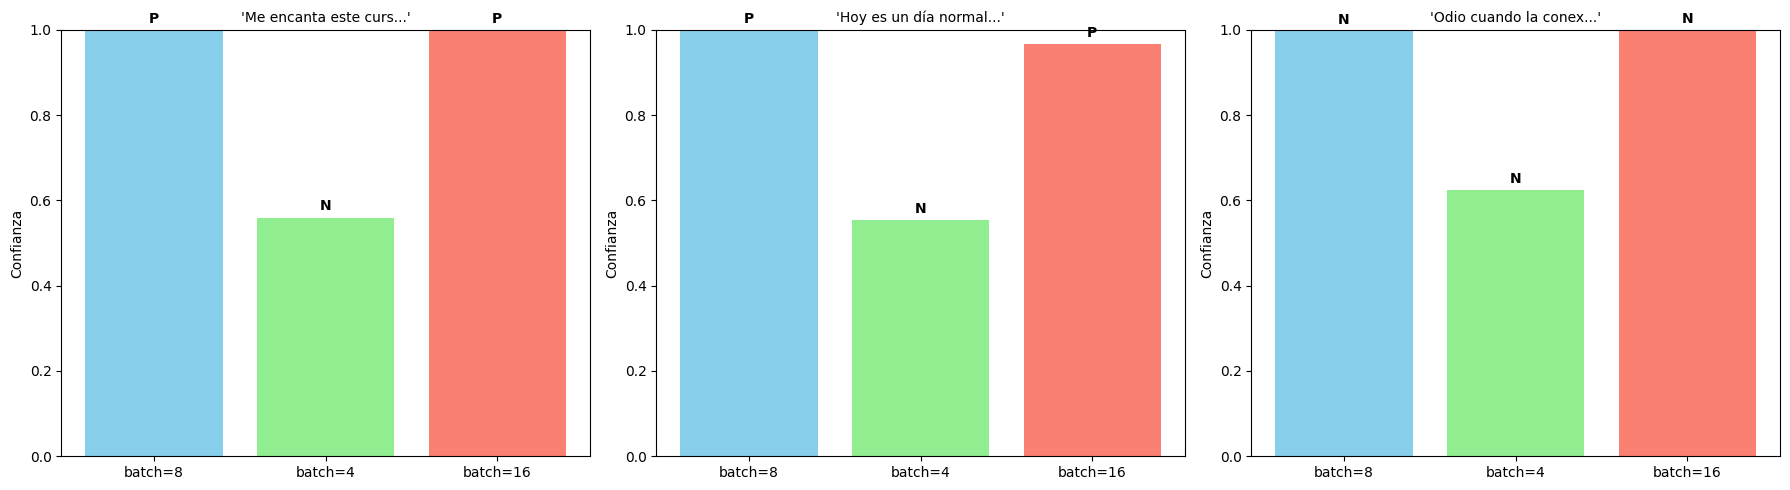

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Ejemplos de prueba (misma lista para todos)
examples = [
    "Me encanta este curso de PLN",
    "Hoy es un día normal, nada especial",
    "Odio cuando la conexión a internet falla"
]

# Predicciones de cada modelo
preds8 = [predict8(ex) for ex in examples]
preds4 = [predict4(ex) for ex in examples]
preds16 = [predict16(ex) for ex in examples]

# Crear DataFrame comparativo
data = []
for i, text in enumerate(examples):
    data.append({
        "Texto": text,
        "Modelo": "batch=8",
        "Etiqueta": preds8[i]["label"],
        "Confianza": preds8[i]["confidence"]
    })
    data.append({
        "Texto": text,
        "Modelo": "batch=4",
        "Etiqueta": preds4[i]["label"],
        "Confianza": preds4[i]["confidence"]
    })
    data.append({
        "Texto": text,
        "Modelo": "batch=16",
        "Etiqueta": preds16[i]["label"],
        "Confianza": preds16[i]["confidence"]
    })

df_compare = pd.DataFrame(data)

# Mostrar tabla
print("Comparación de los tres modelos:")
print(df_compare.to_string(index=False))

# Visualización: gráfico de barras por texto
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, text in enumerate(examples):
    subset = df_compare[df_compare["Texto"] == text]
    colors = ['skyblue', 'lightgreen', 'salmon']
    bars = axes[idx].bar(subset["Modelo"], subset["Confianza"], color=colors)
    axes[idx].set_title(f"'{text[:20]}...'", fontsize=10)
    axes[idx].set_ylim(0, 1)
    axes[idx].set_ylabel("Confianza")
    # Añadir etiquetas de clase encima de cada barra
    for bar, label in zip(bars, subset["Etiqueta"]):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, label,
                       ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()